In [548]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score
from sklearn.model_selection import train_test_split

%matplotlib inline

In [584]:
df = pd.read_csv("data/train.csv", index_col=0)
# df['Deck'] = df[~df['Cabin'].isnull()]['Cabin'].str[0]
df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
df['FamSize'] = df['Parch'] + df['SibSp']

decks_df = df['Cabin'].str.extract('(?P<Deck>\w)(?P<CabinNumber>\d+)', expand=True)
deck_dummies = pd.get_dummies(decks_df['Deck'], prefix='Deck')
title_dummies = pd.get_dummies(df['Title'])
gender_dummies = pd.get_dummies(df['Sex'])
class_dummies = pd.get_dummies(df['Pclass'], prefix='Class')
embarked_dummies = pd.get_dummies(df['Embarked'])
has_age = df['Age'].notnull().astype('int')
has_age.name = 'has_age'

# saving to variables and using .concat() once seems to be much faster
df = pd.concat([df, decks_df, deck_dummies, title_dummies, gender_dummies, class_dummies, 
                embarked_dummies, has_age], axis=1)
df['Age'].fillna(0, inplace=True)

### Use Ridge regression to impute ages

In [550]:
X_train_age = df[df['Age'].notnull()][df.corr().columns]
X_needs_age = df[df['Age'].isnull()][df.corr().columns]
y_train_age = X_train_age.pop('Age')
X_needs_age = X_needs_age.drop('Age', axis=1)
ridge_age = RidgeCV()

ridge_age.fit(X_train_age, y_train_age)
age_pred = np.array(ridge_age.predict(X_needs_age)) + 10

df.loc[df['Age'].isnull(), ('Age')] = age_pred

In [585]:
age_pred.min()

0.34779284498095109

In [552]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

(array([  55.,   52.,  184.,  178.,  174.,  140.,   68.,   29.,    9.,    2.]),
 array([  0.35,   8.31,  16.28,  24.24,  32.21,  40.17,  48.14,  56.1 ,
         64.07,  72.03,  80.  ]),
 <a list of 10 Patch objects>)

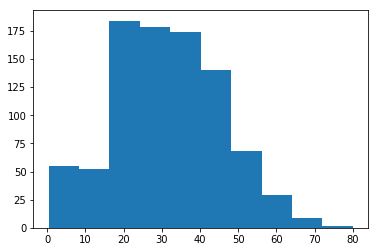

In [553]:
plt.hist(df['Age'])

In [554]:
has_age.sum()

714

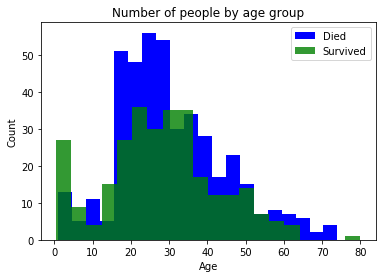

In [555]:
plt.hist(df[(df['Survived'] == 0) & (df['has_age'] == 1)]['Age'], color='b', label='Died', bins=20)
plt.hist(df[(df['Survived'] == 1) & (df['has_age'] == 1)]['Age'], color='g', alpha=0.8, label='Survived', bins=20)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Number of people by age group')
plt.legend()
plt.show()

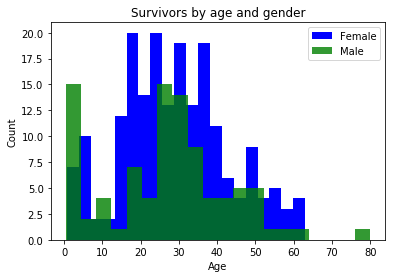

In [556]:
male_survivor_ages = df[(df['Survived'] == 1) & (df['has_age'] == 1) & (df['male'] == 1)]['Age']
female_survivor_ages = df[(df['Survived'] == 1) & (df['has_age'] == 1) & (df['female'] == 1)]['Age']

plt.hist(female_survivor_ages, color='b', label='Female', bins=20)
plt.hist(male_survivor_ages, color='g', label='Male', bins=20, alpha=.8)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Survivors by age and gender')
plt.legend()
plt.show()

### Logistic Regression (no feature engineering)

In [557]:
X_min = df[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]
y_min = X_min.pop('Survived')

In [558]:
df[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']].describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,31.645717,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.252846,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.347793,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,31.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,40.193510,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [560]:
X_train_minimal, X_test_minimal, y_train_minimal, y_test_minimal = train_test_split(X_min, y_min)

logreg_min = LogisticRegressionCV(n_jobs=-1)

logreg_min.fit(X_train_minimal, y_train_minimal)

y_pred = logreg_min.predict(X_test_minimal)

cfn_matrix_minimal = confusion_matrix(y_test_minimal, y_pred)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[112  22]
 [ 59  30]]


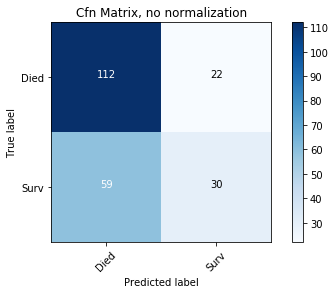

In [561]:
plt.figure()
plot_confusion_matrix(cfn_matrix_minimal, ['Died', 'Surv'], title="Cfn Matrix, no normalization")

Normalized confusion matrix
[[ 0.84  0.16]
 [ 0.66  0.34]]


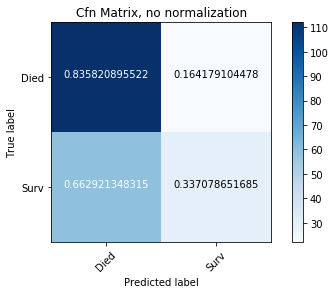

In [562]:
plt.figure()
plot_confusion_matrix(cfn_matrix_minimal, ['Died', 'Surv'], normalize=True, title="Cfn Matrix, no normalization")

In [563]:
print(classification_report(y_test_minimal, y_pred, target_names=['Died', 'Surv']))

             precision    recall  f1-score   support

       Died       0.65      0.84      0.73       134
       Surv       0.58      0.34      0.43        89

avg / total       0.62      0.64      0.61       223



In [571]:
logreg_min.score(X_test_minimal,y_test_minimal)

0.63677130044843044

In [572]:
logreg_min.score(X_min,y_min)

0.71604938271604934

In [573]:
precision_score(y_test_minimal, y_pred)

0.57692307692307687

In [574]:
recall_score(y_test_minimal, y_pred)

0.33707865168539325

### Logistic Regression (with added features)

In [575]:
X = df[df.corr().columns]
y = X.pop('Survived')

In [576]:
X.describe()

,Pclass,Age,SibSp,Parch,Fare,FamSize,Deck_A,Deck_B,Deck_C,Deck_D,...,the Countess,female,male,Class_1,Class_2,Class_3,C,Q,S,has_age
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.00000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,31.645717,0.523008,0.381594,32.204208,0.904602,0.016835,0.052750,0.066218,0.03367,...,0.001122,0.352413,0.647587,0.242424,0.206510,0.551066,0.188552,0.086420,0.722783,0.801347
std,0.836071,14.252846,1.102743,0.806057,49.693429,1.613459,0.128725,0.223659,0.248802,0.18048,...,0.033501,0.477990,0.477990,0.428790,0.405028,0.497665,0.391372,0.281141,0.447876,0.399210
min,1.000000,0.347793,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.000000,31.000000,0.000000,0.000000,14.454200,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,3.000000,40.193510,1.000000,0.000000,31.000000,1.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200,10.000000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [577]:
X_train_features, X_test_features, y_train_features, y_test_features = train_test_split(X, y)

logreg = LogisticRegressionCV(n_jobs=-1)

logreg.fit(X_train_features, y_train_features)

y_pred = logreg.predict(X_test_features)

cfn_matrix_features = confusion_matrix(y_test_features, y_pred)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[114  24]
 [ 23  62]]


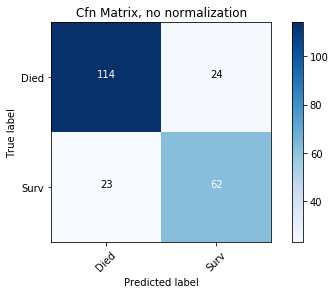

In [578]:
plt.figure()
plot_confusion_matrix(cfn_matrix_features, ['Died', 'Surv'], title="Cfn Matrix, no normalization")

Normalized confusion matrix
[[ 0.83  0.17]
 [ 0.27  0.73]]


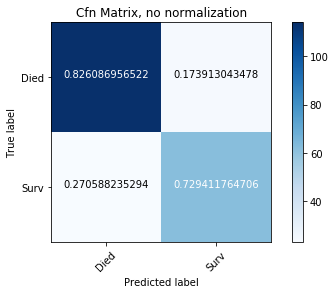

In [579]:
plt.figure()
plot_confusion_matrix(cfn_matrix_features, ['Died', 'Surv'], normalize=True, title="Cfn Matrix, no normalization")

In [580]:
print(classification_report(y_test_features, y_pred, target_names=['Died', 'Surv']))

             precision    recall  f1-score   support

       Died       0.83      0.83      0.83       138
       Surv       0.72      0.73      0.73        85

avg / total       0.79      0.79      0.79       223



In [581]:
logreg.score(X, y)

0.83726150392817056

In [582]:
precision_score(y_test_features, y_pred)

0.72093023255813948

In [583]:
recall_score(y_test_features, y_pred)

0.72941176470588232

In [336]:
logreg.C_

array([ 2.78])

In [337]:
logreg.Cs_

array([  1.00e-04,   7.74e-04,   5.99e-03,   4.64e-02,   3.59e-01,
         2.78e+00,   2.15e+01,   1.67e+02,   1.29e+03,   1.00e+04])

In [338]:
sum(y_test_features)/len(y_test_features)

0.38565022421524664